Jon V

May 7

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets

# Read in dataset.

In [16]:
# read in calculation data (computed elsewhere)
str_pref = '/Users/jonpvandermause/Desktop/store/'

# read in the calculation data
sim_no = 150
ens = []
seps= []
fours = []

min_en = 0
eq_sep = 0

for n in range(sim_no):
    # load separation, energy, and density
    sep = np.load(str_pref+'sep_store/sep'+str(n)+'.npy')
    en = np.load(str_pref+'en_store/en'+str(n)+'.npy')
    four = np.load(str_pref+'four_store/four'+str(n)+'.npy')

    # put results in a nicer format
    sep = np.reshape(sep,(1,))[0]
    en = np.reshape(en,(1,))[0]['energy']
    four = np.real(four)
    
    # get min energy and equilibrium separation
    if en < min_en:
        min_en = en
        eq_sep = sep

    # store quantities
    ens.append(en)
    seps.append(sep)
    fours.append(four)

print('The minimum energy is '+str(min_en)+' eV. The equilibrium separation is '+str(eq_sep)+' Angstrom.')

The minimum energy is -31.74695245487133 eV. The equilibrium separation is 0.7483221476510067 Angstrom.


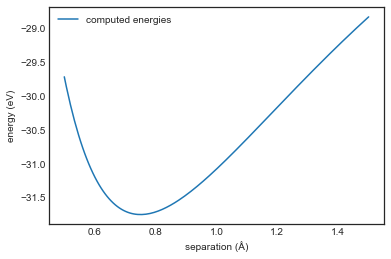

In [17]:
# create figure
figure = plt.figure()
ax = figure.add_subplot(1,1,1)

# add computed energies
ax.plot(seps, ens, label='computed energies')

ax.set_xlabel('separation (Å)')
ax.set_ylabel('energy (eV)')
ax.legend()
plt.show()

# Bayesian network with 2 nodes and biases.

In [168]:
def nn_bias_2(ann_input, ann_output, n_hidden=2, input_dim = 1):

    with pm.Model() as neural_network:
        sd = 0.0001
        
        # set priors on weights and biases
        weights = pm.Normal('weights', 0, sd=10, shape=4)
        
        biases = pm.Normal('biases', 0, sd=10, shape = 3)


        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(ann_input*weights[0]+biases[0])
        act_2 = pm.math.tanh(ann_input*weights[1]+biases[1])
        act_out = act_1*weights[2]+act_2*weights[3]+biases[2]

        # Binary classification -> Bernoulli likelihood
        out = pm.Normal('out', mu = act_out, sd = sd, observed=ann_output)
        
    return neural_network

In [169]:
train_X = train_set
train_Y = -train_ens / 30

ann_input = theano.shared(train_X)
ann_output = theano.shared(train_Y)
neural_network_2 = nn_bias_2(ann_input, ann_output)

with neural_network_2:
    inference = pm.ADVI()
    approx_2 = pm.fit(n=int(3e5), method=inference)

Average Loss = 2.6461e+08:   0%|          | 2911/1000000 [00:02<14:33, 1141.88it/s]
Interrupted at 2,990 [0%]: Average Loss = 3.9727e+08


In [153]:
trace_2 = approx_2.sample(draws=5000)
pm.summary(trace_2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
weights__0,0.733302,0.000198,2.802073e-06,0.732922,0.733689
weights__1,-3.482664,0.000780,9.945367e-06,-3.484172,-3.481127
weights__2,-0.252211,0.000136,1.967120e-06,-0.252473,-0.251936
weights__3,-0.536349,0.000046,6.852183e-07,-0.536440,-0.536261
biases__0,-0.529575,0.000192,2.653625e-06,-0.529952,-0.529197
biases__1,0.799690,0.000418,5.642325e-06,0.798879,0.800528
biases__2,0.555368,0.000044,7.164823e-07,0.555278,0.555451


In [160]:
seps_os = np.linspace(0.1,5,100)

ann_input.set_value(seps_os)
pred_2 = pm.sample_ppc(trace_2, 5000, model=neural_network_2)

100%|██████████| 5000/5000 [00:01<00:00, 3865.87it/s]


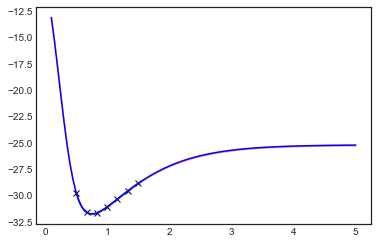

In [164]:
data_pred = pred_2['out']

y_ests = []
y_stds = []
for n in range(seps_os.shape[0]):
    y_est = np.mean(data_pred[:,n])
    y_std = np.std(data_pred[:,n])
    
    y_ests.append(y_est)
    y_stds.append(y_std)
y_ests = -30*np.array(y_ests)
y_stds = 30*np.array(y_stds)

mult = 10

fig, ax = plt.subplots(1,1)

ax.plot(train_set, train_ens, 'kx')
ax.plot(test_set, test_ens)
ax.plot(seps_os, y_ests, 'b')
ax.fill_between(seps_os, y_ests - mult*y_stds, y_ests + mult*y_stds, color='red', alpha=0.3)
plt.show()

In [167]:
y_ests

array([-13.08461186, -15.28697436, -17.71933368, -20.24395872,
       -22.70138354, -24.94590184, -26.87474707, -28.43973289,
       -29.64202284, -30.51610882, -31.11291916, -31.48687546,
       -31.68834908, -31.7597896 , -31.73544909, -31.64158924,
       -31.49846682, -31.32088661, -31.12000887, -30.90410244,
       -30.67893347, -30.44935265, -30.21824676, -29.98829161,
       -29.76095121, -29.5379717 , -29.32017796, -29.10814039,
       -28.90282616, -28.70423448, -28.51302699, -28.3290072 ,
       -28.15254257, -27.9835055 , -27.82197445, -27.66778857,
       -27.52083011, -27.38115298, -27.24844994, -27.12249238,
       -27.00314362, -26.89025854, -26.78351038, -26.68268557,
       -26.58755974, -26.49788182, -26.4133367 , -26.33391532,
       -26.25923565, -26.18908676, -26.12300394, -26.06124643,
       -26.00317879, -25.94881271, -25.89794201, -25.85017499,
       -25.80542698, -25.76377802, -25.72456135, -25.68818217,
       -25.65404202, -25.62222114, -25.59243878, -25.56

# Try Bayesian net with four nodes.

In [311]:
def nn_bias_4(ann_input, ann_output, n_hidden=3):

    with pm.Model() as neural_network:
        sd = 1e-6
        
        # set priors on weights and biases
        weights = pm.Normal('weights', 0, sd=10, shape=8)
        
        biases = pm.Normal('biases', 0, sd=10, shape=5)


        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(ann_input*weights[0]+biases[0])
        act_2 = pm.math.tanh(ann_input*weights[1]+biases[1])
        act_3 = pm.math.tanh(ann_input*weights[2]+biases[2])
        act_4 = pm.math.tanh(ann_input*weights[3]+biases[3])
        
        act_out = pm.Deterministic('act_out',act_1*weights[4]+\
                                   act_2*weights[5]+act_3*weights[6]+\
                                   act_4*weights[7]+biases[4])

        # Binary classification -> Bernoulli likelihood
        out = pm.Normal('out', mu = act_out, sd = sd, observed=ann_output)
        
    return neural_network

In [312]:
train_X = mapminmax(train_set, train_set)
train_Y = mapminmax(train_ens, train_ens)

ann_input = theano.shared(train_X)
ann_output = theano.shared(train_Y)
neural_network_3 = nn_bias_4(ann_input, ann_output)

with neural_network_3:
    inference = pm.ADVI()
    approx_3 = pm.fit(n=int(3e5), method=inference)

Average Loss = 2.1989e+07: 100%|██████████| 300000/300000 [03:54<00:00, 1277.15it/s]
Finished [100%]: Average Loss = 2.1887e+07


In [313]:
trace_3 = approx_3.sample(draws=5000)
pm.summary(trace_3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
weights__0,-0.826211,0.000008,1.018971e-07,-0.826226,-0.826196
weights__1,2.713135,0.000010,1.212497e-07,2.713115,2.713154
weights__2,-0.303548,0.000033,4.867172e-07,-0.303617,-0.303486
weights__3,0.802772,0.000031,4.773872e-07,0.802708,0.802830
weights__4,-1.768240,0.000019,2.769123e-07,-1.768278,-1.768203
weights__5,-2.804106,0.000015,2.230957e-07,-2.804135,-2.804076
weights__6,-0.635559,0.000020,2.591005e-07,-0.635599,-0.635519
weights__7,0.802554,0.000013,1.714310e-07,0.802529,0.802581
biases__0,0.440637,0.000009,1.365081e-07,0.440620,0.440656
biases__1,2.884674,0.000010,1.642784e-07,2.884653,2.884693


In [314]:
seps_os = test_set
seps_os_comp = mapminmax(seps_os, train_set)

ann_input.set_value(seps_os_comp)
pred_3 = pm.sample_ppc(trace_3, 10000, model=neural_network_3)

100%|██████████| 10000/10000 [00:03<00:00, 2929.37it/s]


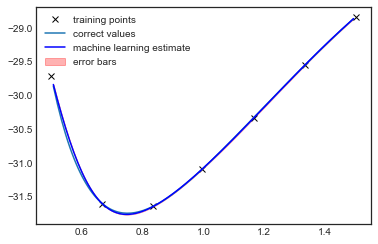

In [315]:
data_pred = pred_3['out']

y_ests = []
y_stds = []
for n in range(seps_os.shape[0]):
    y_est = np.mean(data_pred[:,n])
    y_std = np.std(data_pred[:,n])
    
    y_ests.append(y_est)
    y_stds.append(y_std)
[y_ests, fac_min] = mapminmax_rev(np.array(y_ests), train_ens)
y_stds = fac_min*np.array(y_stds)

mult = 1

fig, ax = plt.subplots(1,1)

ax.plot(train_set, train_ens, 'kx', label='training points')
ax.plot(test_set, test_ens, label='correct values')
ax.plot(seps_os, y_ests, 'b',label='machine learning estimate')
ax.fill_between(seps_os, y_ests - mult*y_stds, y_ests + mult*y_stds, color='red', alpha=0.3, label='error bars')
plt.legend()
plt.show()

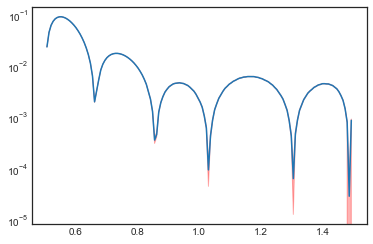

In [316]:
mult = 1
err = np.abs(y_ests-test_ens)
plt.plot(test_set, np.abs(y_ests-test_ens))
plt.fill_between(test_set, err - mult*y_stds, err + mult*y_stds, color='red', alpha=0.3, label='error bars')
plt.yscale('log')

plt.show()

In [317]:
np.mean(err)/0.043

0.3195618656245678

In [296]:
y_stds

array([0.00334143, 0.00328801, 0.00327339, 0.00322013, 0.00318249,
       0.00314375, 0.00312312, 0.00307188, 0.00304237, 0.00298283,
       0.00292703, 0.00292672, 0.00286   , 0.00285501, 0.00281112,
       0.00276421, 0.00275519, 0.00272318, 0.00268004, 0.00265723,
       0.00261984, 0.00263085, 0.00262698, 0.00258009, 0.00256536,
       0.00254317, 0.00252904, 0.00251623, 0.00254046, 0.00252167,
       0.00247993, 0.00248612, 0.0024972 , 0.00248054, 0.00248902,
       0.00247751, 0.00244894, 0.00245999, 0.00248032, 0.00243961,
       0.00242106, 0.00242546, 0.00243256, 0.0024153 , 0.00240354,
       0.00242905, 0.00238833, 0.00241225, 0.00239569, 0.00240343,
       0.00240706, 0.00240477, 0.00236567, 0.00239129, 0.0023741 ,
       0.0023499 , 0.00236782, 0.00235863, 0.00236832, 0.00235587,
       0.00235873, 0.00235709, 0.00232455, 0.0023603 , 0.00236205,
       0.00233487, 0.00234399, 0.00234883, 0.00232405, 0.00234489,
       0.00231727, 0.00232346, 0.0023413 , 0.00234944, 0.00234

# Create Gaussian process.

In [66]:
# create gaussian process model
with pm.Model() as en_model:

    # set hyperparameters for covariance
    rho = pm.HalfCauchy('rho', beta = 50)
    eta = pm.HalfCauchy('eta', beta=1)
    sigma = pm.HalfCauchy('sigma', beta=0.5)
    
    # define covariance function
    K = (eta**2) * pm.gp.cov.ExpQuad(1, rho) 
    
    # create gaussian process model
    lgb_gp = pm.gp.Marginal(cov_func=K)
    y_obs = lgb_gp.marginal_likelihood('y_obs', X=train_set.reshape(-1,1), y=train_ens, noise=0, is_observed=True)
    
    # run the sampler
    step=pm.Metropolis()
    lgb_gp_trace = pm.sample(10000, tune=2000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [sigma_log__]
>Metropolis: [eta_log__]
>Metropolis: [rho_log__]
100%|██████████| 12000/12000 [00:10<00:00, 1171.03it/s]
The number of effective samples is smaller than 10% for some parameters.


In [67]:
# get posterior predictive samples
x_pred = np.array(seps)
samp_size = 2000
with en_model:
    func_pred = lgb_gp.conditional('func_pred', Xnew = x_pred.reshape(-1,1), pred_noise=False)
    data_pred = lgb_gp.conditional('data_pred', Xnew = x_pred.reshape(-1,1), pred_noise=True)
    gp_samples = pm.sample_ppc(lgb_gp_trace, vars=[func_pred, data_pred], samples=2000)

100%|██████████| 2000/2000 [00:14<00:00, 133.77it/s]


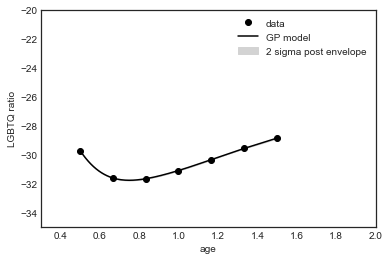

In [68]:
# plot mean predictions with 2 sigma envelope

# plot data
fig, ax = plt.subplots(1,1)
ax.plot(train_set, train_ens,'ok',label='data')

# plot linear model and posterior std
func = gp_samples['func_pred'].mean(0)
mu = gp_samples['data_pred'].mean(0)
sig = 2 * gp_samples['data_pred'].std(0)

ax.plot(x_pred, func, '-k',label='GP model')
ax.fill_between(x_pred, mu - sig, mu + sig, color='lightgray',label='2 sigma post envelope')

ax.set_xlabel('age')
ax.set_ylabel('LGBTQ ratio')
ax.set_xlim(0.3,2)
ax.set_ylim(-35,-20)
plt.legend()

plt.show()

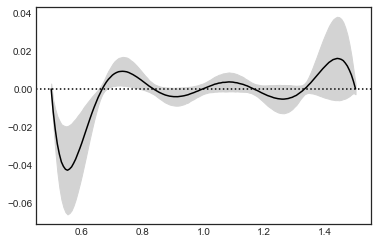

In [69]:
# plot data
fig, ax = plt.subplots(1,1)

errs = np.array(ens) - func
ax.plot(x_pred, errs, '-k',label='GP model')
ax.fill_between(x_pred, errs - sig, errs + sig, color='lightgray',label='2 sigma post envelope')
ax.axhline(0,color='black',ls=':')

plt.show()

In [72]:
np.mean(np.abs(errs))/0.034

0.24034079385617016